In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 120.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
import torch.onnx
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# !pip install torchvision
import torchvision
import glob

import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder


from google.colab import drive
drive.mount('/content/drive')
device = None
if torch.cuda.is_available():
  print("GPU is available!")
  device = torch.device("cuda")  # Set device to GPU
else:
  print("GPU is not available. Using CPU instead.")
  device = torch.device("cpu")

Mounted at /content/drive
GPU is not available. Using CPU instead.


In [ ]:
file_path = '/content/drive/MyDrive/dataset-resized/'
file_path = '/content/drive/MyDrive/evals/'
class CustomDataset(Dataset):
  def __init__(self):
    self.imgs_path = file_path
    file_list = glob.glob(self.imgs_path + "*")
    print(file_list)
    self.data = []
    for class_path in file_list:
        class_name = class_path.split("/")[-1]
        for img_path in glob.glob(class_path + "/*.jpeg"):
            self.data.append([img_path, class_name])
    print(self.data)
    self.class_map = {"others" : 0, "plastic": 1}
    self.img_dim = (416, 416)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img_path, class_name = self.data[idx]
    img = cv2.imread(img_path)
    img = cv2.resize(img, self.img_dim)
    class_id = self.class_map[class_name]
    img_tensor = torch.from_numpy(img)
    img_tensor = img_tensor.permute(2, 0, 1)
    class_id = torch.tensor([class_id])
    return img_tensor, class_id


In [ ]:
class CustomTooDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [ ]:
TRANSFORMS = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomRotation(30),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip(),
])

customDt = CustomTooDataset(file_path, TRANSFORMS)
loadData = DataLoader(customDt, batch_size=32, shuffle=True)
customDtEval = CustomTooDataset(file_path, TRANSFORMS)
loadDataEval = DataLoader(customDt, batch_size=32, shuffle=False)

In [ ]:
class ConvNet(nn.Module):
  def __init__(self, num_classes=2):
    super(ConvNet, self).__init__()
    # Input shape = (batch_size, num_channels, 150, 150)
    self.conv1 = nn.Conv2d(in_channels=3,
                            out_channels=16,
                            kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(num_features=self.conv1.out_channels)
    self.relu1 = nn.ReLU()
    # Shape = (batch_size, 16, 150, 150)
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)
    # Output shape = (batch_size, 16, 75, 75)
    # Input shape = (batch_size, 16, 75, 75)
    self.conv2 = nn.Conv2d(in_channels=self.conv1.out_channels,
                            out_channels=self.conv1.out_channels * 2,
                            kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(num_features=self.conv2.out_channels)
    self.relu2 = nn.ReLU()
    # Shape = (batch_size, 32, 75, 75)
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)
    # Output shape = (batch_size, 32, 37, 37)
    # Input shape = (batch_size, 32, 37, 37)
    self.conv3 = nn.Conv2d(in_channels=self.conv2.out_channels,
                            out_channels=self.conv2.out_channels * 2,
                            kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(num_features=self.conv3.out_channels)
    self.relu3 = nn.ReLU()
    # Shape = (batch_size, 64, 37, 37)
    self.maxpool3 = nn.MaxPool2d(kernel_size=2)
    # Output shape = (batch_size, 64, 18, 18)
    # Input shape = (batch_size, 64, 18, 18)
    self.flatten = nn.Flatten()
    # Output shape = (batch_size, 64*18*18) = (batch_size, 20736)
    # Input shape = (batch_size, 20736)
    self.fc1 = nn.Linear(in_features=self.conv3.out_channels * 28 * 28,
                          out_features=self.conv3.out_channels * 28 * 28 // 4)
    self.relu4 = nn.ReLU()
    self.dropout1 = nn.Dropout(0.5)
    # Output shape = (batch_size, 5184)
    # Input shape = (batch_size, 5184)
    self.fc2 = nn.Linear(in_features=self.fc1.out_features,
                          out_features=self.fc1.out_features // 4)
    self.relu5 = nn.ReLU()
    self.dropout2 = nn.Dropout(0.5)
    # Output shape = (batch_size, 1296)
    # Input shape = (batch_size, 1296)
    self.fc3 = nn.Linear(in_features=self.fc2.out_features,
                          out_features=self.fc2.out_features // 4)
    self.relu6 = nn.ReLU()
    self.dropout3 = nn.Dropout(0.5)
    # Output shape = (batch_size, 324)
    # Input shape = (batch_size, 324)
    self.fc4 = nn.Linear(in_features=self.fc3.out_features,
                          out_features=num_classes)
    # Output shape = (batch_size, 6)

  def forward(self, x):

    output = self.maxpool1(self.relu1(self.bn1(self.conv1(x))))
    output = self.maxpool2(self.relu2(self.bn2(self.conv2(output))))
    output = self.maxpool3(self.relu3(self.bn3(self.conv3(output))))

    output = self.flatten(output)

    output = self.dropout1(self.relu4(self.fc1(output)))
    output = self.dropout2(self.relu5(self.fc2(output)))
    output = self.dropout3(self.relu6(self.fc3(output)))
    output = self.fc4(output)

    return output

In [ ]:
class CNN(nn.Module):
   def __init__(self, in_channels, num_classes):

       """
       Building blocks of convolutional neural network.

       Parameters:
           * in_channels: Number of channels in the input image (for grayscale images, 1)
           * num_classes: Number of classes to predict. In our problem, 10 (i.e digits from  0 to 9).
       """
       super(CNN, self).__init__()

       # 1st convolutional layer
       self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, padding=1)
       # Max pooling layer
       self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
       # 2nd convolutional layer
       self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
       # Fully connected layer
       self.fc1 = nn.Linear(16 * 56 * 56, num_classes)

   def forward(self, x):
       """
       Define the forward pass of the neural network.

       Parameters:
           x: Input tensor.

       Returns:
           torch.Tensor
               The output tensor after passing through the network.
       """
       x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = x.reshape(x.shape[0], -1)  # Flatten the tensor
       x = self.fc1(x)            # Apply fully connected layer
       return x

In [ ]:
for images, labels in loadData:
    break

model1 = CNN(in_channels=3, num_classes=2)
model1.to(device)
out = model1(images.to(device))
out


tensor([[ 0.0767, -0.0008],
        [ 0.0034, -0.0044],
        [ 0.1589, -0.0184],
        [ 0.1472, -0.0534],
        [ 0.1398, -0.0345],
        [ 0.1054, -0.0298],
        [ 0.1300, -0.0600],
        [ 0.0724, -0.0434],
        [ 0.1474, -0.0522],
        [ 0.1342, -0.0767],
        [ 0.1422, -0.0192],
        [ 0.1467, -0.0312],
        [ 0.1647, -0.0044],
        [ 0.1096, -0.0518],
        [ 0.1279, -0.0242],
        [ 0.0870, -0.0283],
        [ 0.0885, -0.0496],
        [ 0.0555, -0.0155],
        [ 0.1053, -0.0217],
        [ 0.0779, -0.0354],
        [ 0.1494, -0.0446],
        [ 0.0317, -0.0346],
        [ 0.1683, -0.0760],
        [ 0.1926, -0.0314],
        [ 0.1070, -0.0325],
        [ 0.1004, -0.0421],
        [ 0.1209, -0.0547],
        [ 0.0980, -0.0370],
        [ 0.0959, -0.0255],
        [ 0.1029, -0.0400],
        [ 0.1702, -0.0238],
        [ 0.1816, -0.0641]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
num_epochs = 100
train_losses, val_losses = [], []


model = CNN(in_channels=3 ,num_classes=2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(loadData, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(loadData.dataset)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(loadDataEval, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(loadDataEval.dataset)
    val_losses.append(val_loss)


Validation loop: 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


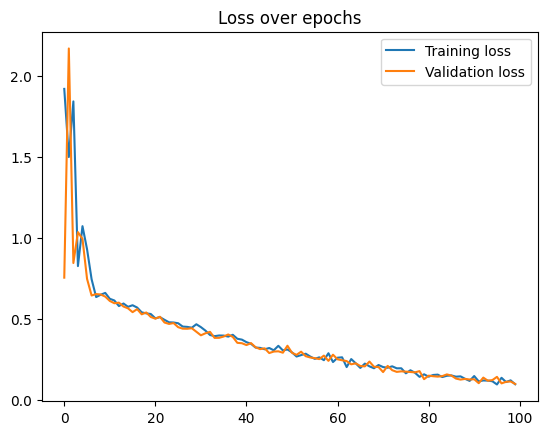

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [ ]:
model.eval()

dummyInput = torch.randn(1, 3, 224, 224).to(device)
torch.onnx.export(model,
                  dummyInput,
                  "/content/model_plastic.onnx",
                  export_params=True,
                  opset_version=11,
                  do_constant_folding=True,
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})